In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

#from dfply import arrange

from sklearn.utils import resample
from sklearn.metrics import cohen_kappa_score, make_scorer

from sklearn.model_selection import BaseCrossValidator

In [ ]:
import rpy2
import rpy2.robjects as robjects

In [3]:
#path1 = "/home/rsrg9/Documents/tunc_oz/apply_model"
path1 = "D:/tunc_oz/apply_model"
os.chdir(path1)

# Second path
path2 = "csv_data_r_import/cologne/scale"
os.chdir(path2)

In [74]:
import numpy as np
from sklearn import datasets
from sklearn import svm
from sklearn.model_selection import cross_val_score

X, y = datasets.load_iris(return_X_y=True)
X.shape, y.shape

def custom_cv_2folds(X):
    n = X.shape[0]
    i = 1
    while i <= 2:
        idx = np.arange(n * (i - 1) / 2, n * i / 2, dtype=int)
        yield idx, idx
        i += 1
custom_cv = custom_cv_2folds(X)
clf = svm.SVC(kernel='linear', C=1, random_state=42)
cross_val_score(clf, X, y, cv=custom_cv)

array([1.        , 0.97333333])

In [75]:
custom_cv

<generator object custom_cv_2folds at 0x000001E977252970>

In [14]:
def svm_fit(x, y, custom_splitter=None):
    # Expand coarse grid
    coarse_grid = {'C': 2.0 ** np.arange(-4, 13, 2),
                   'gamma': 2.0 ** np.arange(-5, 4, 2)}
    
    kappa_scorer = make_scorer(cohen_kappa_score)

    # Coarse grid search
    svm_coarse = SVC(kernel='rbf')
    svm_coarse_cv = GridSearchCV(svm_coarse, param_grid=coarse_grid, scoring=kappa_scorer)#, cv=custom_splitter)
    svm_coarse_cv.fit(x, y)
    
    # Get best coarse grid parameters
    best_c = svm_coarse_cv.best_params_['C']
    best_gamma = svm_coarse_cv.best_params_['gamma']
    
    # Define narrow grid borders
    a_gamma = np.log2(best_gamma) - 2
    b_gamma = np.log2(best_gamma) + 2
    a_c = np.log2(best_c) - 2
    b_c = np.log2(best_c) + 2
    
    # Expand narrow grid
    narrow_grid = {'C': 2.0 ** np.arange(a_c, b_c, 0.5),
                   'gamma': 2.0 ** np.arange(a_gamma, b_gamma, 0.5)}
    
    # Narrow grid search
    svm_narrow = SVC(kernel='rbf')
    svm_narrow_cv = GridSearchCV(svm_narrow, param_grid=narrow_grid, scoring=kappa_scorer)#, cv=custom_splitter)
    svm_narrow_cv.fit(x, y)
    
    return svm_narrow_cv

# Usage example:
# svm_model = svm_fit(X_train, y_train, StratifiedKFold(n_splits=10, shuffle=True))

#### Utils

In [5]:
# Euclidean Distance between two points lying in the input space
def euc_dis(a, b):
    temp = 0
    for ii in range(len(a)):
        temp += (a[ii] - b[ii])**2
    return np.sqrt(temp)

# Evaluate the distance between Virtual Support Vectors and Support Vectors lying in the input space
def rem_extrem(org, VSV1, a):
    distance = pd.DataFrame(index=range(len(org)), columns=['label', 'distance'])
    distanceSVC1 = []
    distanceSVC2 = []
    
    for l in range(len(org)):
        distance.loc[l, 'label'] = str(org.iloc[l, -1])
        distance.loc[l, 'distance'] = euc_dis(org.iloc[l, :-1], VSV1.iloc[l, :-1])
    
    SVClass1 = org[org['REF'] == org['REF'].unique()[0]]
    SVClass2 = org[org['REF'] == org['REF'].unique()[1]]
    
    if len(SVClass1) > 0:
        for n in range(len(SVClass1) - 1):
            for nn in range(n, len(SVClass1) - 1):
                distanceSVC1.append(euc_dis(SVClass1.iloc[n, :-1], SVClass1.iloc[n + nn, :-1]))
        disClass1median = np.mean(distanceSVC1)
        boundClass1 = disClass1median * a
    
    if len(SVClass2) > 0:
        for n in range(len(SVClass2) - 1):
            for nn in range(n, len(SVClass2) - 1):
                distanceSVC2.append(euc_dis(SVClass2.iloc[n, :-1], SVClass2.iloc[n + nn, :-1]))
        disClass2median = np.mean(distanceSVC2)
        boundClass2 = disClass2median * a
    
    for k in range(len(org)):
        if np.isnan(distance.loc[k, 'distance']):
            VSV1.iloc[k, :] = np.nan
        else:
            if boundClass1 is not None:
                if distance.loc[k, 'label'] == org['REF'].unique()[0]:
                    if distance.loc[k, 'distance'] > boundClass1:
                        VSV1.iloc[k, :] = np.nan
            else:
                if boundClass2 is not None:
                    if distance.loc[k, 'label'] == org['REF'].unique()[1]:
                        if distance.loc[k, 'distance'] > boundClass2:
                            VSV1.iloc[k, :] = np.nan
    return VSV1

# Kernel distance between two points lying in the hyperspace
def kern_dis(a, b, kernelfunc):
    a = np.array(a).flatten()
    b = np.array(b).flatten()
    dk = np.sqrt(kernelfunc(a, a) + kernelfunc(b, b) - 2 * kernelfunc(a, b))
    return dk

# Evaluate the distance between Virtual Support Vectors and Support Vectors lying in the hyperspace
def rem_extrem_kerneldist(org, VSV1, a, kernelfunc):
    distance = pd.DataFrame(index=range(len(org)), columns=['label', 'distance'])
    distanceSVC1 = []
    distanceSVC2 = []
    
    for l in range(len(org)):
        distance.loc[l, 'label'] = str(org.iloc[l, -1])
        distance.loc[l, 'distance'] = kern_dis(org.iloc[l, :-1], VSV1.iloc[l, :-1], kernelfunc)
    
    SVClass1 = org[org['REF'] == org['REF'].unique()[0]]
    SVClass2 = org[org['REF'] == org['REF'].unique()[1]]
    
    if len(SVClass1) > 0:
        for n in range(len(SVClass1) - 1):
            for nn in range(n, len(SVClass1) - 1):
                distanceSVC1.append(kern_dis(SVClass1.iloc[n, :-1], SVClass1.iloc[n + nn, :-1], kernelfunc))
        disClass1median = np.mean(distanceSVC1)
        boundClass1 = disClass1median * a
    
    if len(SVClass2) > 0:
        for n in range(len(SVClass2) - 1):
            for nn in range(n, len(SVClass2) - 1):
                distanceSVC2.append(kern_dis(SVClass2.iloc[n, :-1], SVClass2.iloc[n + nn, :-1], kernelfunc))
        disClass2median = np.mean(distanceSVC2)
        boundClass2 = disClass2median * a
    
    for k in range(len(org)):
        if np.isnan(distance.loc[k, 'distance']):
            VSV1.iloc[k, :] = np.nan
        else:
            if boundClass1 is not None:
                if distance.loc[k, 'label'] == org['REF'].unique()[0]:
                    if distance.loc[k, 'distance'] > boundClass1:
                        VSV1.iloc[k, :] = np.nan
            else:
                if boundClass2 is not None:
                    if distance.loc[k, 'label'] == org['REF'].unique()[1]:
                        if distance.loc[k, 'distance'] > boundClass2:
                            VSV1.iloc[k, :] = np.nan
    return VSV1

def pred_one(model, data_point):
    # Extract necessary components from the SVM model
    support_vectors = model.n_support_
    kernel_function = model.kernel
    coefficients = model.dual_coef_.ravel()
    intercept = model.intercept_
    
    # Initialize prediction variable
    prediction = 0
    
    # Iterate over each support vector
    for j in range(len(support_vectors)):
        # Compute kernel function value between the j-th support vector and the data point
        kernel_value = kernel_function(data_point.reshape(1, -1), model.support_vectors_[j, :].reshape(1, -1))
        
        # Multiply kernel value by the corresponding coefficient and add to prediction
        weighted_value = kernel_value * coefficients[j]
        prediction += weighted_value
    
    # Subtract intercept to get the final prediction
    final_prediction = prediction - intercept
    
    return final_prediction

def uncertainty_dist_v2_2(org, samp):
    distance = pd.DataFrame(columns=['control_label', 'distance'], index=range(len(samp)))
    
    for k in range(len(samp)):
        distance.loc[k, 'distance'] = np.sign(pred_one(org.finalModel, samp.iloc[k, :-1])) * \
                                      np.where(pred_one(org.finalModel, samp.iloc[k, :-1]) > 0, 1, -1)
    
    # Normalize distance
    preProc = preprocessing.MinMaxScaler()
    preProc.fit(distance[['distance']])
    normdistance = preProc.transform(distance[['distance']])
    
    samp['normdistance'] = normdistance
    
    return samp

def alter_labels(distance_data, ref):
    # Merge features and original labels
    ref_added = pd.concat([distance_data, ref], axis=1)
    # Order by most uncertain samples
    ref_added_or = ref_added.sort_values(by='distance')
    # Re-label most uncertain n number of samples
    ref_added_or.iloc[:250, -1] = ref_added_or.iloc[:250, -2]
    ref_added_or.iloc[:250, -2] = 1.0
    # Re-order dataset by its index
    ref_added_or['index'] = range(len(ref_added_or))
    ref_added_reor = ref_added_or.sort_values(by='index')
    
    # Extract labels for prediction
    labels = ref_added_reor.iloc[:, -5]
    return labels

def ExCsvMSD(datadase, filename=None):
    # Convert to numpy array
    datadase = np.array(datadase)
    n = datadase.shape[1]
    MSDdata = np.empty((2, n), dtype=float)
    
    MSDdata[0, :] = np.mean(datadase, axis=0)
    MSDdata[1, :] = np.std(datadase, axis=0)
    
    MSDdata_final = np.vstack((datadase, MSDdata))
    
    # Export final mean and standard deviation to .csv-file
    if filename is not None:
        pd.DataFrame(MSDdata_final).to_csv(filename, index=False, header=False)
    
    return MSDdata_final

#### Inputs

In [6]:
inputPath = "cologne_res_100_L2-L13.csv"
sMax = 1000
bound = [0.3, 0.6, 0.9]
boundMargin = [1.5, 1.0, 0.5]
sampleSizesPor = [40, 25, 16, 12, 10, 8, 6, 4, 3, 2, 1]
colheader = ["40", "25", "16", "12", "10", "8", "6", "4", "3", "2", "1"]
sindexSVMDATA = 36
numFeat = 18
eindexSVMDATA = sindexSVMDATA + numFeat - 1
objInfoNames = ["Lx_g_comp", "Lx_g_elfi", "Lx_g_refi", "Lx_g_roun", "Lx_g_shin",
                "Lx_m_bl", "Lx_m_gr", "Lx_m_ndvi", "Lx_m_nir", "Lx_m_re",
                "Lx_sd_bl", "Lx_sd_gr", "Lx_sd_ndvi", "Lx_sd_nir", "Lx_sd_re",
                "Lx_t_diss", "Lx_t_hom", "Lx_t_mean",
                "label"]
columnClass = [None] * 217 + ["factor", "integer"]

# Import data
preproc_DataPool = pd.read_csv(inputPath, header=0, sep=";", dtype=str, na_values=None)

tmp_DataPool = preproc_DataPool.iloc[:, :-2]

generalDataPool_columns = tmp_DataPool.columns

converters = {col: lambda x: float(x.replace(',', '.')) for col in generalDataPool_columns}
generalDataPool = pd.read_csv(inputPath, header=0, sep=";", na_values=None, converters=converters)


generalDataPool.dropna(subset=["REF"], inplace=True)  # Remove rows with missing REF values
generalDataPool["REF"] = pd.Categorical(generalDataPool["REF"])

# Transform to 2-Class-Case "Bushes Trees" VS rest
first_label_class = generalDataPool["REF"].cat.categories[0]  # Note that the first record is of class "bushes trees"
generalDataPool["REF"] = generalDataPool["REF"].apply(lambda x: first_label_class if x == first_label_class else "other")
generalDataPool["REF"] = pd.Categorical(generalDataPool["REF"])

data = generalDataPool.iloc[:, sindexSVMDATA:eindexSVMDATA + 1]
REF = generalDataPool.iloc[:, -1]
data_with_label = pd.concat([data, REF], axis=1)
data_label = data_with_label.iloc[:, -1]

In [ ]:
#generalDataPool.dtypes

In [18]:
#normalizedFeat['L02_G_COMP'] = normalizedFeat['L02_G_COMP'].replace(',', '.', regex=True)
#normalizedFeat['L02_G_COMP'] = normalizedFeat['L02_G_COMP'].astype(float)

In [ ]:
#normalizedFeat['L02_G_EFIT'] = normalizedFeat['L02_G_EFIT'].apply(lambda x: pd.to_numeric(x.str.replace(',', '.'), errors='coerce'))

In [16]:
normalizedFeat = generalDataPool.iloc[:, :-2]
normalizedLabelUSE = generalDataPool.iloc[:, -2:]

# Scaling
preProc = MinMaxScaler()
normalizedFeatBase = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, sindexSVMDATA:eindexSVMDATA + 1]), columns=objInfoNames[:-1])

# Apply range of basemodel to all levels
normalizedFeat2 = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, :numFeat]), columns=objInfoNames[:-1])
normalizedFeat3 = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, numFeat:(2 * numFeat)]), columns=objInfoNames[:-1])
normalizedFeat5 = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, (3 * numFeat):(4 * numFeat)]), columns=objInfoNames[:-1])
normalizedFeat6 = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, (4 * numFeat):(5 * numFeat)]), columns=objInfoNames[:-1])
normalizedFeat7 = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, (5 * numFeat):(6 * numFeat)]), columns=objInfoNames[:-1])
normalizedFeat8 = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, (6 * numFeat):(7 * numFeat)]), columns=objInfoNames[:-1])
normalizedFeat9 = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, (7 * numFeat):(8 * numFeat)]), columns=objInfoNames[:-1])
normalizedFeat10 = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, (8 * numFeat):(9 * numFeat)]), columns=objInfoNames[:-1])
normalizedFeat11 = pd.DataFrame(preProc.fit_transform(normalizedFeat.iloc[:, (9 * numFeat):(10 * numFeat)]), columns=objInfoNames[:-1])

# Recombine normalized sets to one data frame
normalizedDataPoolAllLev = pd.concat([normalizedFeat2, normalizedFeat3, normalizedFeatBase, normalizedFeat5,
                                      normalizedFeat6, normalizedFeat7, normalizedFeat8, normalizedFeat9,
                                      normalizedFeat10, normalizedFeat11, normalizedLabelUSE], axis=1)

# Remove used temporary variables
del normalizedFeat, normalizedFeat2, normalizedFeat3, normalizedFeatBase, normalizedFeat5, normalizedFeat6
del normalizedFeat7, normalizedFeat8, normalizedFeat9, normalizedFeat10, normalizedFeat11


In [17]:
# Split data into test, train, and validate data
trainDataPoolAllLev, testDataAllLev, validateDataAllLev = [df for _, df in normalizedDataPoolAllLev.groupby('USE')]
trainDataPoolAllLev = trainDataPoolAllLev.iloc[:, :-1]
testDataAllLev = testDataAllLev.iloc[:, :-1]
validateFeatAllLev = validateDataAllLev.iloc[:, :-2]
validateLabels = validateDataAllLev.iloc[:, -2]

# Order train data pool by class label in alphabetical order
trainDataPoolAllLev = trainDataPoolAllLev.sort_values(by=trainDataPoolAllLev.columns[-1])

# Current training data-set, updated (refreshed) after each iteration
trainDataCur = trainDataPoolAllLev.copy()
testDataCur = testDataAllLev.copy()

# Set randomized seed for the random sampling procedure
seed = 5

# Initial seed value for randomized sampling
seed += np.random.randint(1, 101)

# Definition of apriori-probabilities
pA = pB = pC = pD = pE = pF = 1 / 6

# Definition of training sample set sizes S [% of max. sample size]
sCur = sMax * (sampleSizesPor[0] / 100)
# Definition of sample shares
nA, nB, nC, nD, nE, nF = [round(sCur * p) for p in [pA, pB, pC, pD, pE, pF]]
shares = np.array([nA, nB, nC, nD, nE, nF])

# Set randomized seed for the random sampling procedure
np.random.seed(seed)

In [ ]:
#validateDataAllLev.columns[-2]

In [32]:
#stratSamp = trainDataCur.groupby('REF', observed=False)[trainDataCur.columns].apply(lambda x: x.sample(67, replace=False))

In [32]:
stratSamp.columns

Index(['Lx_g_comp', 'Lx_g_elfi', 'Lx_g_refi', 'Lx_g_roun', 'Lx_g_shin',
       'Lx_m_bl', 'Lx_m_gr', 'Lx_m_ndvi', 'Lx_m_nir', 'Lx_m_re',
       ...
       'Lx_sd_bl', 'Lx_sd_gr', 'Lx_sd_ndvi', 'Lx_sd_nir', 'Lx_sd_re',
       'Lx_t_diss', 'Lx_t_hom', 'Lx_t_mean', 'REF', 'ID_unit'],
      dtype='object', length=182)

In [34]:
# Define the sampling function
def sample_within_group(group):
    # Add the original IDs as a new column
    group['ID_unit'] = group.index
    
    # Perform sampling within the group
    sampled_group = group.sample(min(len(group), 67), replace=False)
    
    return sampled_group

# Apply the sampling function to each group
stratSamp = trainDataCur.groupby('REF', observed=False).apply(sample_within_group)

# Reset the index to obtain a flat DataFrame with the original IDs preserved
stratSamp.reset_index(drop=True, inplace=True)

# Get samples of trainDataCur and set trainDataCur new
trainDataCurRemaining = trainDataCur.drop(stratSamp["ID_unit"])

# Split test feat from test label for later join with trainData
trainFeat = stratSamp.iloc[:, :len(trainDataPoolAllLev.columns)-1]
trainLabels = stratSamp.iloc[:, len(trainDataPoolAllLev.columns)-1]

In [ ]:
#len(trainDataPoolAllLev.columns)

In [35]:
trainFeat.columns

Index(['Lx_g_comp', 'Lx_g_elfi', 'Lx_g_refi', 'Lx_g_roun', 'Lx_g_shin',
       'Lx_m_bl', 'Lx_m_gr', 'Lx_m_ndvi', 'Lx_m_nir', 'Lx_m_re',
       ...
       'Lx_m_nir', 'Lx_m_re', 'Lx_sd_bl', 'Lx_sd_gr', 'Lx_sd_ndvi',
       'Lx_sd_nir', 'Lx_sd_re', 'Lx_t_diss', 'Lx_t_hom', 'Lx_t_mean'],
      dtype='object', length=180)

In [36]:
stratSamp.columns[len(trainDataPoolAllLev.columns)-1]

'REF'

In [30]:
#stratSamp = trainDataCur.groupby('REF',observed=False)
#stratSamp = stratSamp.apply(lambda x: x.sample(67, replace=False))

In [ ]:
# Definition of sampling configuration (strata: random sampling without replacement)
#stratSamp = trainDataCur.groupby('REF').apply(lambda x: x.sample(shares, replace=False)).reset_index(drop=True)

In [ ]:
#trainDataCur.columns[-1]

In [ ]:
#stratSamp.iloc[:,181]

In [ ]:
#stratSamp["ID_unit"]

In [ ]:
#trainFeat.describe

In [37]:
len(trainDataCur.columns)

181

In [114]:
class CustomSplitter(BaseCrossValidator):
    def __init__(self, index_train):
        self.index_train = index_train

    def split(self, X, y=None, groups=None):
        test_indices = np.setdiff1d(np.arange(len(X)), self.index_train)
        yield self.index_train, test_indices

class CustomSplitter(BaseCrossValidator):
    def __init__(self, index_train):
        self.index_train = index_train

    def split(self, X, y=None, groups=None):
        test_indices = np.setdiff1d(np.arange(len(X)), self.index_train)
        yield self.index_train, test_indices

    def get_n_splits(self, X=None, y=None, groups=None):
        return 1  # Since you're doing a single split, return 1

In [38]:

# Subset for each outer iteration test data to speed up computing
testDataCur = testDataCur.sort_values(by=testDataCur.columns[-1])
# Apply the sampling function to each group
stratSamp = testDataCur.groupby('REF', observed=False).apply(sample_within_group)

# Split test feat from test label for later join with trainData
testFeat = stratSamp.iloc[:, :len(testDataCur.columns)-1]
testLabels = stratSamp.iloc[:, len(testDataCur.columns)-1]

# Subset on base level
testFeatsub = testFeat.iloc[:, sindexSVMDATA:eindexSVMDATA + 1]

# TrainData index to split between train and test in svmFit
countTrainData = trainFeat.shape[0]
indexTrainData = [list(range(countTrainData))]

# SVM base for invariants

# Subset on L_4
trainFeat = trainFeat.iloc[:, sindexSVMDATA:eindexSVMDATA + 1]

# Join train and test data (separable through indexTrainData in svmFit)
tuneFeat = pd.concat([trainFeat, testFeatsub], axis=0)
tuneLabel = np.concatenate((trainLabels.values, testLabels.values))

validateFeatsub = validateFeatAllLev.iloc[:, sindexSVMDATA:eindexSVMDATA+1]

In [25]:
np.array(range(countTrainData))

In [40]:
trainFeat.columns

Index(['Lx_g_comp', 'Lx_g_elfi', 'Lx_g_refi', 'Lx_g_roun', 'Lx_g_shin',
       'Lx_m_bl', 'Lx_m_gr', 'Lx_m_ndvi', 'Lx_m_nir', 'Lx_m_re', 'Lx_sd_bl',
       'Lx_sd_gr', 'Lx_sd_ndvi', 'Lx_sd_nir', 'Lx_sd_re', 'Lx_t_diss',
       'Lx_t_hom', 'Lx_t_mean'],
      dtype='object')

In [20]:
countTrainData = trainFeat.shape[0]
indexTrainData = np.array(range(countTrainData))

# SVM base for invariants

# Subset on L_4
trainFeat = trainFeat.iloc[:, sindexSVMDATA:eindexSVMDATA + 1]

# Join train and test data (separable through indexTrainData in svmFit)
tuneFeat = pd.concat([trainFeat, testFeatsub], axis=0)
tuneLabel = np.concatenate((trainLabels.values, testLabels.values))

custom_splitter = CustomSplitter(indexTrainData)

# SVM parameter tuning
svm_model=svm_fit(tuneFeat, tuneLabel)#, custom_splitter)

ValueError: 
All the 225 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_base.py", line 192, in fit
    X, y = self._validate_data(
  File "C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
  File "C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 921, in check_array
    _assert_all_finite(
  File "C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\validation.py", line 161, in _assert_all_finite
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [23]:
tuneFeat.shape

(268, 18)

In [41]:
# SVM parameter tuning
svm_model=svm_fit(tuneFeat, tuneLabel)

In [24]:
trainLabels.unique()
trainLabels.value_counts()

bushes_trees    67
other           67
Name: REF, dtype: int64

In [42]:
# Predict labels of test data
predLabelsSVM = svm_model.predict(validateFeatsub)

# Accuracy assessment
accSVM = accuracy_score(validateLabels, predLabelsSVM)
print(accSVM)

0.848417300936329


In [43]:
tuneFeat.shape

(268, 18)

In [48]:
tuneFeat.iloc[:, 0]

0                  0.075430
1                  0.091789
2                  0.090829
3                  0.109521
4                  0.103880
                     ...   
(other, 432248)    0.204029
(other, 556566)    0.128527
(other, 371635)    0.130255
(other, 539219)    0.115283
(other, 433992)    0.032179
Name: Lx_g_comp, Length: 268, dtype: float64

C:\Users\Utente\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


ValueError: X has 2 features, but SVC is expecting 18 features as input.

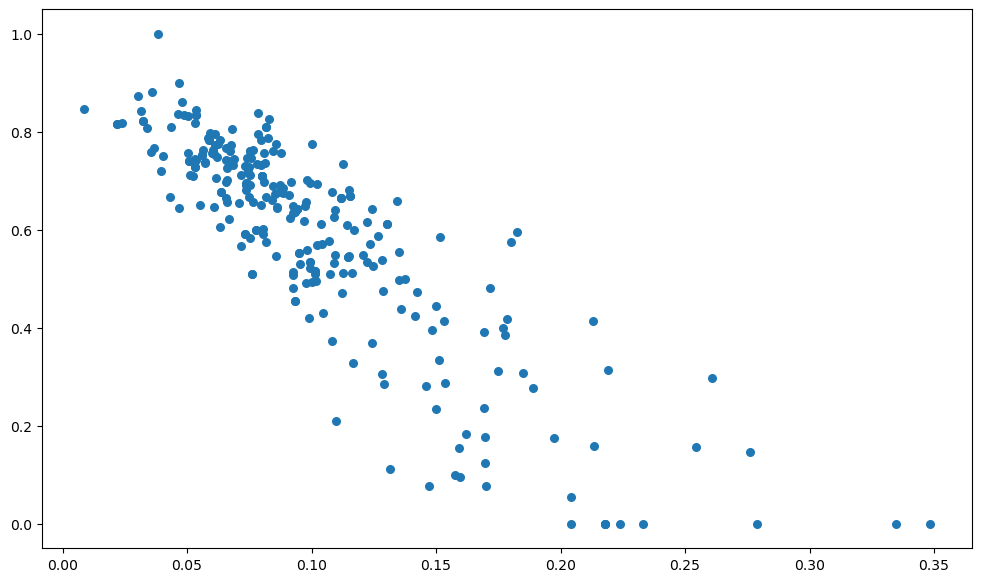

In [50]:
from matplotlib import pyplot as plt
plt.figure(figsize=(12,7))

plt.scatter(tuneFeat.iloc[:, 0], tuneFeat.iloc[:, 1], s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
#evaluate the SVM value for the positive class
Z = svm_model.best_estimator_.decision_function(xy).reshape(XX.shape)

# plot decision boundary (w^Tx =  0) and margins (w^Tx = 1 and w^Tx = -1)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(svm_model.best_estimator_.support_vectors_[:, 0], svm_model.best_estimator_.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

In [27]:
#trainDataCur.columns.shape

(181,)

In [121]:
trainDataCur['REF'].unique()
trainDataCur['REF'].value_counts()


other           357365
bushes_trees     48420
Name: REF, dtype: int64

In [62]:
svm_model.n_features_in_

18

In [122]:
svm_model.classes_

array(['bushes_trees', 'other'], dtype=object)

In [64]:
svm_model.best_estimator_.support_vectors_[:4]

array([[0.11770877, 0.263158  , 0.61822079, 0.44276951, 0.14035688,
        0.02920971, 0.0208755 , 0.55691075, 0.06458741, 0.0222087 ,
        0.06751957, 0.05327685, 0.17553671, 0.07652946, 0.05125174,
        0.18771871, 0.03578111, 0.79301248],
       [0.08841473, 0.675841  , 0.82627553, 0.21814325, 0.13382892,
        0.02696745, 0.01792254, 0.4641897 , 0.04431946, 0.02005523,
        0.03643325, 0.02949871, 0.30568572, 0.08655693, 0.02822726,
        0.12758109, 0.04270372, 0.81109333],
       [0.04809533, 0.861538  , 0.89016515, 0.08527873, 0.12648156,
        0.03207706, 0.02740113, 0.51226972, 0.06290198, 0.02909166,
        0.04648648, 0.04678275, 0.59508436, 0.15669978, 0.05465299,
        0.10566308, 0.06175637, 0.79804385],
       [0.20875686, 0.        , 0.41692503, 0.47196826, 0.29781484,
        0.02770935, 0.02053573, 0.51643706, 0.05501459, 0.02121302,
        0.03990251, 0.03671958, 0.24703117, 0.08141916, 0.02936107,
        0.17569506, 0.02934755, 0.80734324]])

In [66]:
SVindex

array([  2,   9,  14,  15,  18,  19,  23,  27,  28,  29,  30,  38,  39,
        51,  59,  60,  64,  68,  72,  73,  75,  78,  84,  97,  99, 103,
       111, 112, 114, 115, 117, 119, 121, 129, 131])

In [67]:
trainDataCur.iloc[SVindex, list(range(sindexSVMDATA,eindexSVMDATA+1))+[-1]][:4]

,Lx_g_comp,Lx_g_elfi,Lx_g_refi,Lx_g_roun,Lx_g_shin,Lx_m_bl,Lx_m_gr,Lx_m_ndvi,Lx_m_nir,Lx_m_re,Lx_sd_bl,Lx_sd_gr,Lx_sd_ndvi,Lx_sd_nir,Lx_sd_re,Lx_t_diss,Lx_t_hom,Lx_t_mean,REF
141566,0.068239,0.805668,0.873817,0.141781,0.092888,0.033785,0.032189,0.620288,0.100116,0.036525,0.040698,0.037860,0.405775,0.165309,0.044026,0.090419,0.052963,0.796689,bushes_trees
35439,0.094363,0.594595,0.789575,0.273995,0.186283,0.029562,0.038956,0.658483,0.126350,0.045296,0.087441,0.108569,0.624496,0.336826,0.159947,0.146974,0.050292,0.826420,bushes_trees
101611,0.073022,0.670330,0.798266,0.201985,0.077653,0.021294,0.014574,0.631935,0.061670,0.007359,0.026509,0.022434,0.316412,0.119451,0.020073,0.098026,0.060738,0.803718,bushes_trees
101610,0.052193,0.707317,0.819672,0.142156,0.049890,0.033915,0.035445,0.678320,0.109000,0.029649,0.026247,0.020902,0.091693,0.051384,0.018004,0.213381,0.016879,0.770114,bushes_trees


In [51]:
trainDataCur[:4]

,Lx_g_comp,Lx_g_elfi,Lx_g_refi,Lx_g_roun,Lx_g_shin,Lx_m_bl,Lx_m_gr,Lx_m_ndvi,Lx_m_nir,Lx_m_re,...,Lx_m_re,Lx_sd_bl,Lx_sd_gr,Lx_sd_ndvi,Lx_sd_nir,Lx_sd_re,Lx_t_diss,Lx_t_hom,Lx_t_mean,REF
109760,0.171857,0.666667,0.713605,0.238544,0.152226,0.034789,0.036164,0.453214,0.061155,0.049238,...,0.139337,0.038537,0.026021,0.000079,0.044961,0.017197,0.033769,0.648476,0.135342,bushes_trees
141565,0.081891,0.650000,0.838557,0.131868,0.097356,0.033760,0.037295,0.722255,0.123907,0.044875,...,0.119707,0.023619,0.016966,0.000091,0.068199,0.015982,0.028416,0.689078,0.203255,bushes_trees
141566,0.081891,0.650000,0.838557,0.131868,0.097356,0.033760,0.037295,0.722255,0.123907,0.044875,...,0.119707,0.023619,0.016966,0.000091,0.068199,0.015982,0.028416,0.689078,0.203255,bushes_trees
101618,0.292604,0.037037,0.477876,0.597481,0.375123,0.030327,0.031084,0.709437,0.096326,0.031764,...,0.119707,0.023619,0.016966,0.000091,0.068199,0.015982,0.028416,0.689078,0.203255,bushes_trees


In [68]:
svm_model.best_estimator_.support_.shape

(82,)

In [69]:
SVtotal.shape

(35, 19)

In [135]:
trainDataCur.iloc[svm_model.best_estimator_.support_, -1].value_counts()


bushes_trees    217
other             0
Name: REF, dtype: int64

In [133]:
svm_model.best_estimator_.support_

array([  1,   2,   3,   4,   6,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  42,  43,  44,
        45,  46,  47,  48,  49,  50,  52,  53,  54,  55,  58,  59,  60,
        62,  63,  65,  66, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 152, 153, 155, 156, 157,
       158, 159, 160, 161, 163, 164, 165, 166, 168, 169, 170, 171, 172,
       174, 176, 177, 178, 180, 181, 182, 189, 190, 192, 193, 194, 195,
       196, 197, 199, 200,  67,  68,  70,  71,  72,  73,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  85,  86,  87,  89,  90,  91,  92,
        93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 108,
       109, 112, 113, 118, 119, 120, 121, 123, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 201, 202, 204, 205, 206, 208, 209, 210, 211,
       212, 213, 214, 215, 217, 218, 219, 221, 222, 223, 224, 22

In [12]:
# VSVM on all Level SV
SVindex = svm_model.best_estimator_.support_  # Indices of support vectors
SVtotal = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA,eindexSVMDATA+1))+[-1]].reset_index(drop=True)  # Get support vectors

SVL2 = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA - 2 * numFeat,sindexSVMDATA - numFeat))+[-1] ].reset_index(drop=True)
SVL3 = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA - numFeat,sindexSVMDATA))+[-1] ].reset_index(drop=True)

SVL5 = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA + numFeat,sindexSVMDATA + 2 * numFeat))+[-1] ].reset_index(drop=True)
SVL6 = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA + 2 * numFeat,sindexSVMDATA + 3 * numFeat))+[-1] ].reset_index(drop=True)
SVL7 = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA + 3 * numFeat,sindexSVMDATA + 4 * numFeat))+[-1] ].reset_index(drop=True)
SVL8 = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA + 4 * numFeat,sindexSVMDATA + 5 * numFeat))+[-1] ].reset_index(drop=True)
SVL9 = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA + 5 * numFeat,sindexSVMDATA + 6 * numFeat))+[-1] ].reset_index(drop=True)
SVL10 = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA + 6 * numFeat,sindexSVMDATA + 7 * numFeat))+[-1] ].reset_index(drop=True)
SVL11 = trainDataCur.iloc[SVindex, list(range(sindexSVMDATA + 7 * numFeat,sindexSVMDATA + 8 * numFeat))+[-1] ].reset_index(drop=True)


# Bind original SV with modified to new train data set
SVinvar = pd.concat([SVtotal, SVL2, SVL3, SVL5, SVL6, SVL7, SVL8, SVL9, SVL10, SVL11],ignore_index=True)

# Split for training to feature and label
trainFeatVSVM = SVinvar.iloc[:, :-1].reset_index(drop=True)
trainLabelsVSVM = SVinvar.iloc[:, -1]

# Get list with index of train data to split between train and test in svmFit
countTrainData = SVinvar.shape[0]
indexTrainData = [list(range(1, countTrainData + 1))]

In [ ]:
#trainLabelsVSVM.dtype

In [ ]:
#trainFeatVSVM.count()

In [ ]:
#tuneFeatVSVM.count()

In [ ]:
#tuneFeatVSVM.isna()

In [13]:
# Join of train and test test data (through indexTrainData in svmFit separable)
tuneFeatVSVM = pd.concat([trainFeatVSVM, testFeatsub])
tuneLabelsVSVM = np.concatenate((trainLabelsVSVM.values, testLabels.values))

# VSVM parameter tuning
tunedVSVM = svm_fit(tuneFeatVSVM, tuneLabelsVSVM)

# Run classification and accuracy assessment for modified SV
predLabelsVSVM = tunedVSVM.predict(validateFeatsub)
accVSVM = accuracy_score(validateLabels, predLabelsVSVM)
print(accVSVM)

0.8049789543475848


In [ ]:
#pd.merge(trainFeatVSVM, testFeatsub, how='inner')

In [ ]:
#trainFeatVSVM[0:10].reset_index(drop=True)

In [ ]:
#testFeatsub[0:10].reset_index(drop=True)

In [ ]:
#pd.concat([SVtotal,SVL2,SVL5])

In [14]:
# VSVM - EVALUATION of all Level VSV
actKappa = 0
bestFittingModel = None

# Iteration over bound to test different bound thresholds determining the radius of acceptance
for jj in bound:
    SVinvarRadi = pd.concat([
    rem_extrem(SVtotal, SVL2, jj).set_axis(objInfoNames, axis=1),
    rem_extrem(SVtotal, SVL3, jj).set_axis(objInfoNames, axis=1),
    rem_extrem(SVtotal, SVL5, jj).set_axis(objInfoNames, axis=1),
    rem_extrem(SVtotal, SVL6, jj).set_axis(objInfoNames, axis=1),
    rem_extrem(SVtotal, SVL7, jj).set_axis(objInfoNames, axis=1),
    rem_extrem(SVtotal, SVL8, jj).set_axis(objInfoNames, axis=1),
    rem_extrem(SVtotal, SVL9, jj).set_axis(objInfoNames, axis=1),
    rem_extrem(SVtotal, SVL10, jj).set_axis(objInfoNames, axis=1),
    rem_extrem(SVtotal, SVL11, jj).set_axis(objInfoNames, axis=1),
    # rem_extrem(SVtotal, SVL12, bound[jj]).set_axis(objInfoNames, axis=1),
    # rem_extrem(SVtotal, SVL13, bound[jj]).set_axis(objInfoNames, axis=1)
    ])    
    # Iterating over boundMargin to test different thresholds on margin distance
    for kk, bound_margin_val in enumerate(boundMargin):
        SVinvar_list = []
        
        # Iterate over SVinvarRadi and evaluate distance to hyperplane
        for m in range(len(SVinvarRadi)):
            signa = pred_one(tunedVSVM, SVinvarRadi[m, :-1])
            if SVinvarRadi[m, -1] == levels(generalDataPool.REF)[0]:
                if -bound_margin_val < signa < bound_margin_val:
                    SVinvar_list.append(SVinvarRadi[m, :])
            else:
                if -bound_margin_val < signa < bound_margin_val:
                    SVinvar_list.append(SVinvarRadi[m, :])

        SVinvar = pd.DataFrame(SVinvar_list, columns=objInfoNames)
        
        # Merge elected VSV with original SV
        SVinvar_org = pd.concat([SVtotal, SVinvar])

        # Split for training to feature and label
        trainFeatVSVM = SVinvar_org.iloc[:, :-1]
        trainLabelsVSVM = SVinvar_org.iloc[:, -1]

        # Get list with index of trainData to split between train and test in svmFit
        countTrainData = SVinvar_org.shape[0]
        indexTrainData = [list(range(1, countTrainData + 1))]

        # Join of train and test data (through indexTrainData in svmFit separable)
        names = objInfoNames[:-1]
        tuneFeatVSVM = pd.concat([trainFeatVSVM, testFeatsub], axis=0)
        tuneFeatVSVM.columns = names
        tuneLabelsVSVM = np.concatenate((trainLabelsVSVM.values, testLabels.values))

        ######################################## VSVM control parameter tuning ########################################
        tunedVSVM = SVC(kernel='linear')
        tunedVSVM.fit(tuneFeatVSVM, tuneLabelsVSVM)

        # Get the best fitting model based on Kappa
        if actKappa < tunedVSVM.resample.Kappa:
            bestFittingModel = tunedVSVM
            actKappa = tunedVSVM.resample.Kappa

# Run classification and accuracy assessment for the best bound setting
# Predict labels of test data
predLabelsVSVMsum = bestFittingModel.predict(validateFeatsub)

# Accuracy assessment
accVSVM_SL = accuracy_score(validateLabels, predLabelsVSVMsum)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:



# Balanced & Random unlabeled samples
# Balanced samples

# Definition of sampling configuration (strata: random sampling without replacement)
stratSampRemaining_b = resample(trainDataCurRemaining, n_samples=[b, b, b, b, b, b], replace=False)
samplesRemaining_b = trainDataCurRemaining.iloc[stratSampRemaining_b]

trainDataCurRemaining_b = samplesRemaining_b.iloc[:, :-1]
trainDataCurRemainingsub_b = trainDataCurRemaining_b.iloc[:, sindexSVMDATA:eindexSVMDATA]
REF_b = bestFittingModel.predict(trainDataCurRemainingsub_b)

SVindexUn_b = np.arange(1, len(trainDataCurRemainingsub_b) + 1)
SVtotalUn_b = trainDataCurRemaining_b.iloc[SVindexUn_b - 1, sindexSVMDATA:eindexSVMDATA]
SVtotalUn_b['REF'] = REF_b

SVL2Un_b = trainDataCurRemaining.iloc[SVindexUn_b - 1, sindexSVMDATA - 2*numFeat:sindexSVMDATA - numFeat - 1].copy()
SVL2Un_b['REF'] = REF_b
SVL3Un_b = trainDataCurRemaining.iloc[SVindexUn_b - 1, sindexSVMDATA - numFeat:sindexSVMDATA - 1].copy()
SVL3Un_b['REF'] = REF_b
SVL5Un_b = trainDataCurRemaining_b.iloc[SVindexUn_b - 1, sindexSVMDATA + numFeat:sindexSVMDATA + 2*numFeat - 1].copy()
SVL5Un_b['REF'] = REF_b
SVL6Un_b = trainDataCurRemaining_b.iloc[SVindexUn_b - 1, sindexSVMDATA + 2*numFeat:sindexSVMDATA + 3*numFeat - 1].copy()
SVL6Un_b['REF'] = REF_b
SVL7Un_b = trainDataCurRemaining_b.iloc[SVindexUn_b - 1, sindexSVMDATA + 3*numFeat:sindexSVMDATA + 4*numFeat - 1].copy()
SVL7Un_b['REF'] = REF_b
SVL8Un_b = trainDataCurRemaining_b.iloc[SVindexUn_b - 1, sindexSVMDATA + 4*numFeat:sindexSVMDATA + 5*numFeat - 1].copy()
SVL8Un_b['REF'] = REF_b
SVL9Un_b = trainDataCurRemaining_b.iloc[SVindexUn_b - 1, sindexSVMDATA + 5*numFeat:sindexSVMDATA + 6*numFeat - 1].copy()
SVL9Un_b['REF'] = REF_b
SVL10Un_b = trainDataCurRemaining_b.iloc[SVindexUn_b - 1, sindexSVMDATA + 6*numFeat:sindexSVMDATA + 7*numFeat - 1].copy()
SVL10Un_b['REF'] = REF_b
SVL11Un_b = trainDataCurRemaining_b.iloc[SVindexUn_b - 1, sindexSVMDATA + 7*numFeat:sindexSVMDATA + 8*numFeat - 1].copy()
SVL11Un_b['REF'] = REF_b

SVinvarUn_b = pd.concat([SVtotalUn_b, SVL2Un_b, SVL3Un_b, SVL5Un_b, SVL6Un_b, SVL7Un_b, SVL8Un_b, SVL9Un_b, SVL10Un_b, SVL11Un_b])

# Balanced Unlabeled samples

actKappa = 0

for jj in range(len(bound)):
    SVinvarRadiUn_b_list = []
    for m in range(len(SVinvarRadiUn_b)):
        signa = pred_one(tunedSVM.finalModel, SVinvarRadiUn_b.iloc[m, :-1])
        if SVinvarRadiUn_b.iloc[m, -1] == levels(generalDataPool.REF)[0]:
            if -bound_margin_val < signa < bound_margin_val:
                SVinvarRadiUn_b_list.append(SVinvarRadiUn_b.iloc[m, :])
        else:
            if -bound_margin_val < signa < bound_margin_val:
                SVinvarRadiUn_b_list.append(SVinvarRadiUn_b.iloc[m, :])

    SVinvarUn_b = pd.DataFrame(SVinvarRadiUn_b_list, columns=objInfoNames)
    
    SVinvar_orgUn_b = pd.concat([SVtotal, SVinvarUn_b])

    trainFeatVSVMUn_b = SVinvar_orgUn_b.iloc[:, :-1]
    trainLabelsVSVMUn_b = SVinvar_orgUn_b.iloc[:, -1]

    countTrainDataUn_b = SVinvar_orgUn_b.shape[0]
    indexTrainDataUn_b = [list(range(1, countTrainDataUn_b + 1))]

    names = objInfoNames[:-1]
    tuneFeatVSVMUn_b = pd.concat([trainFeatVSVMUn_b, testFeatsub], axis=0)
    tuneFeatVSVMUn_b.columns = names
    tuneLabelsVSVMUn_b = np.concatenate((trainLabelsVSVMUn_b.values, testLabels.values))

    tunedVSVMUn_b = SVC(kernel='linear')
    tunedVSVMUn_b.fit(tuneFeatVSVMUn_b, tuneLabelsVSVMUn_b)

    if actKappa < tunedVSVMUn_b.resample.Kappa:
        bestFittingModelUn_b = tunedVSVMUn_b
        actKappa = tunedVSVMUn_b.resample.Kappa

# Run classification and accuracy assessment for the best bound setting
predLabelsVSVMsumUn_b = bestFittingModelUn_b.predict(validateFeatsub)

# Accuracy assessment
accVSVM_SL_Un_b = accuracy_score(validateLabels, predLabelsVSVMsumUn_b)


In [ ]:
# Add predicted labels to the features data set
predLabelsVSVMsumUn_unc = pd.concat([validateFeatsub, pd.DataFrame(predLabelsVSVMsumUn_b, columns=["Predicted_Labels"])], axis=1)
predLabelsVSVMsumUn_unc.columns = objInfoNames

# Calculate uncertainty of the samples by selecting SV's and data set
normdistvsvm_sl_un = uncertainty_dist_v2_2(bestFittingModelUn_b, predLabelsVSVMsumUn_unc)

# Alter labels
predlabels_vsvm_Slu = alter_labels(normdistvsvm_sl_un, validateLabels)

# Accuracy assessment
accVSVM_SL_Un_b_ad = accuracy_score(validateLabels, predlabels_vsvm_Slu)
